In [68]:
from __future__ import print_function
import numpy as np
np.random.seed(1)
import sys
import sklearn
import sklearn.ensemble
# %load_ext autoreload
# %autoreload 2
from anchor import utils
from anchor import anchor_tabular
import pandas as pd
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 

In [69]:
#@title Preprocess the data

# Read data
df = pd.read_csv('compas-scores-two-years.csv')

# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['days_b_screening_arrest'].notnull()]

# Rename recidivism column
df['recidivism_within_2_years'] = df['is_recid']

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

df = pd.get_dummies(df, columns=['sex', 'race', 'c_charge_degree'])
df['duration'] = df['end'] - df['start']

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['sex_Male', 'age', 'c_charge_degree_F', 'race_African-American', 'race_Caucasian',
                  'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count', 'juv_fel_count',
                  'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest','c_days_from_compas', 'duration']

to_keep = input_features + ['recidivism_within_2_years', 'COMPASS_determination']

to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)

input_columns = df.columns.tolist()
labels = df['COMPASS_determination']
df.head(20)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,recidivism_within_2_years,COMPASS_determination,sex_Male,race_African-American,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,duration
0,69,0,0,0,0,-1.0,1.0,0,0,True,False,False,False,False,True,True,327
1,34,0,0,0,0,-1.0,1.0,1,0,True,True,False,False,False,False,True,150
2,24,0,0,1,4,-1.0,1.0,1,0,True,True,False,False,False,False,True,63
5,44,0,0,0,0,0.0,0.0,0,0,True,False,False,False,False,True,False,852
6,41,0,0,0,14,-1.0,1.0,1,1,True,False,True,False,False,False,True,35
7,43,0,0,0,3,-1.0,1.0,0,0,True,False,False,False,False,True,True,265
8,39,0,0,0,0,-1.0,1.0,0,0,False,False,True,False,False,False,False,745
9,21,0,0,0,1,428.0,308.0,1,0,True,False,True,False,False,False,True,428
10,27,0,0,0,0,-1.0,1.0,0,0,True,False,True,False,False,False,True,857
11,23,0,0,0,3,0.0,0.0,1,1,True,True,False,False,False,False,False,124


In [70]:
df.columns.tolist()

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_days_from_compas',
 'recidivism_within_2_years',
 'COMPASS_determination',
 'sex_Male',
 'race_African-American',
 'race_Caucasian',
 'race_Hispanic',
 'race_Native American',
 'race_Other',
 'c_charge_degree_F',
 'duration']

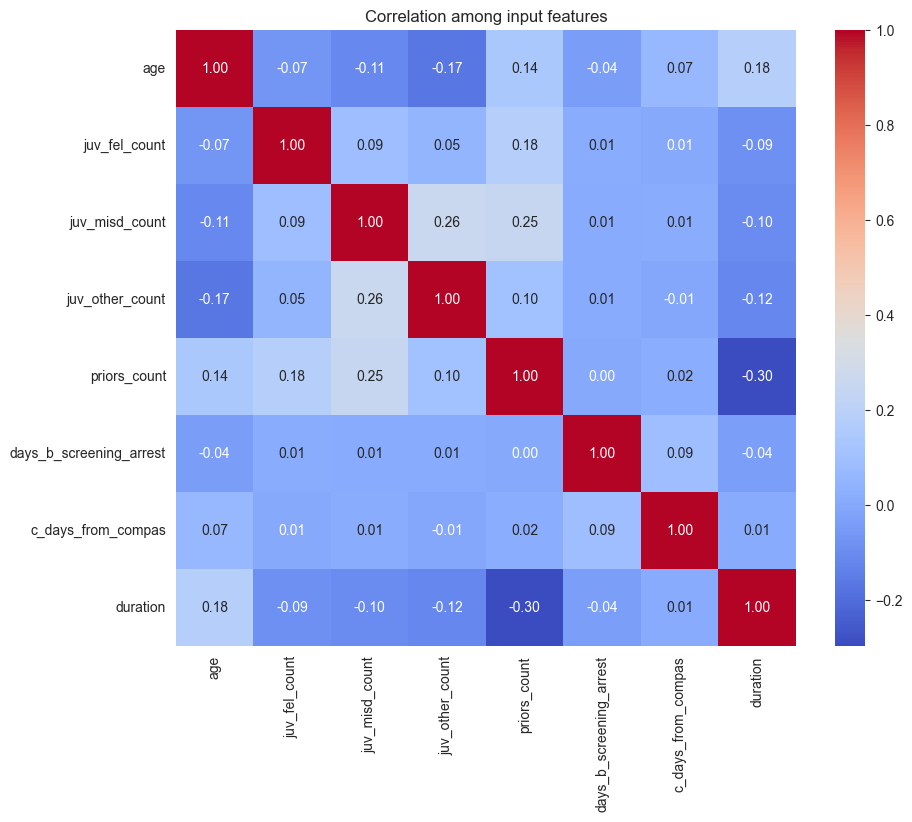

In [71]:
#@title Analyze data before training
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df = numeric_df.drop(columns = ['recidivism_within_2_years'])
corr_matrix = numeric_df.corr()

# corrplot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation among input features')
plt.show()

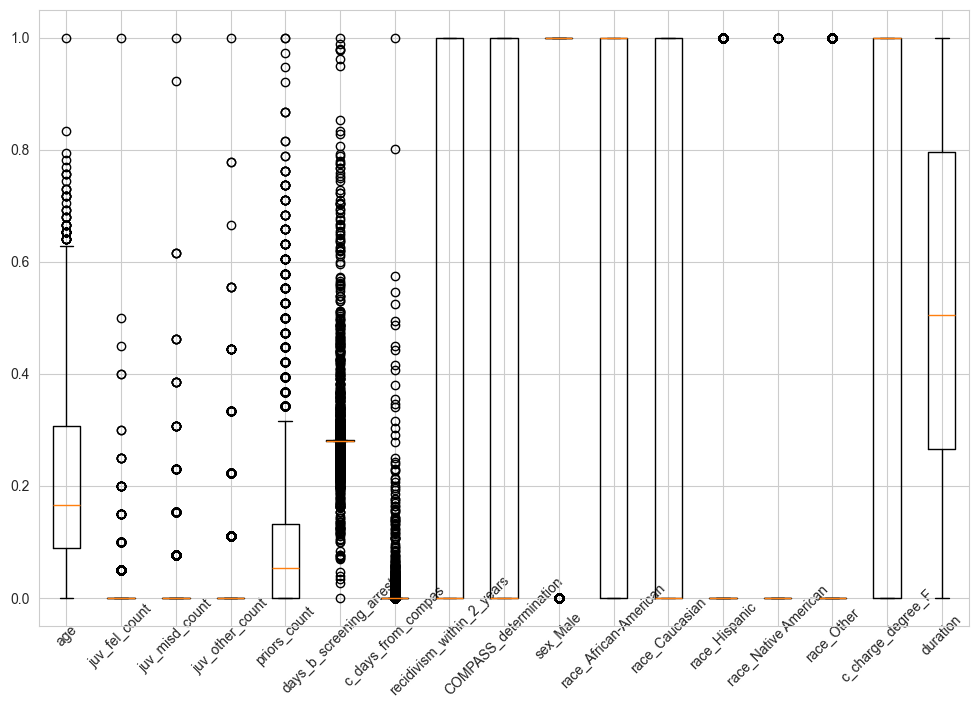

In [72]:


# Normalize the data
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Specify columns to normalize
columns_to_normalize = numeric_df.columns

# Fit and transform the specified columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Check for outliers in the normalized data
fig = plt.figure(figsize=(12, 8))
plt.boxplot(df, labels=df.columns)
plt.xticks(rotation=45, va='center')  # Ensure correct x-axis labels
plt.show()

In [73]:
#@title Create data structures needed for training and testing
# The training data doesn't contain the column we are predicting,
# 'COMPASS_determination', or the column we are using for evaluation of our
# trained model, 'recidivism_within_2_years'.
df_for_training = df.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
train_size = int(len(df_for_training) * 0.8)
train_data = df_for_training[:train_size]
train_labels = labels[:train_size]

test_data_with_labels = df[train_size:]
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
test_labels = labels[train_size:]

In [74]:
# Load the saved model
model = load_model("Models/dnn_model.h5")

# Fit AnchorExplainer
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=[0,1],  # Specify class names
    feature_names=df.columns.tolist(),
    train_data=train_data.values,
    categorical_names={'sex_Male': ['True', 'False'],
 'race_African-American': ['True', 'False'],
 'race_Caucasian': ['True', 'False'],
 'race_Hispanic': ['True', 'False'],
 'race_Native American': ['True', 'False'],
 'race_Other': ['True', 'False'],
 'c_charge_degree_F': ['True', 'False']}  # If any of your features are categorical, specify their names here
)

# Generate explanations for a specific instance
idx = 0  # Index of the instance to explain
explanation = explainer.explain_instance(test_data.iloc[idx].values, model.predict)

# Print the explanation
print(explanation)

C:\Users\adrie\Documents\DACS\XAI\Project\xai-compas-um\venv\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [86]:

import tensorflow as tf

class RoundLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(RoundLayer, self).__init__()

    def call(self, inputs):
        rounded_values = tf.round(inputs)
        return tf.cast(rounded_values, dtype=tf.int32)

# Load the model
model = load_model("Models/dnn_model.h5")

# Create a new model with the rounding layer applied
rounded_model = tf.keras.Sequential([
    model,
    RoundLayer()
])

# Now predict using the rounded_model
rounded_prediction = rounded_model.predict(test_data.iloc[idx].values.reshape(1, -1))[0]
print(rounded_prediction)


# Convert boolean values to integers if necessary
test_data['sex_Male'] = test_data['sex_Male'].astype(int)
test_data['race_African-American'] = test_data['race_African-American'].astype(int)
test_data['race_Caucasian'] = test_data['race_Caucasian'].astype(int)
test_data['race_Hispanic'] = test_data['race_Hispanic'].astype(int)
test_data['race_Native American'] = test_data['race_Native American'].astype(int)
test_data['race_Other'] = test_data['race_Other'].astype(int)
test_data['c_charge_degree_F'] = test_data['c_charge_degree_F'].astype(int)
# Repeat for other boolean features if necessary

# Assuming test_data is your DataFrame
for column in test_data.columns:
    if test_data[column].dtype == 'float64':  # Check if the column dtype is float
        test_data[column] = test_data[column].astype(int)  # Cast float to int

explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=[0,1],  # Specify class names
    feature_names=df.columns.tolist(),
    train_data=train_data.values,
    categorical_names={'sex_Male': [True, False],
 'race_African-American': [True, False],
 'race_Caucasian': [True, False],
 'race_Hispanic': [True, False],
 'race_Native American': [True, False],
 'race_Other': [True, False],
 'c_charge_degree_F': [True, False]}  # If any of your features are categorical, specify their names here
)
# Generate explanations for a specific instance
# idx = 1  # Index of the instance to explain
# print(test_data.iloc[idx].values)
# explanation = explainer.explain_instance(test_data.iloc[idx].values, model.predict)
# 
# # Print the explanation
# print(explanation)

print(test_data.dtypes)

idx = 0
np.random.seed(1)
# print('Prediction: ', explainer.class_names[rounded_model.predict(test_data.iloc[idx].values.reshape(1, -1))[0]])
exp = explainer.explain_instance(test_data.iloc[idx].values, rounded_model.predict, threshold=0.95)

C:\Users\adrie\Documents\DACS\XAI\Project\xai-compas-um\venv\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[0]
age                        int32
juv_fel_count              int32
juv_misd_count             int32
juv_other_count            int32
priors_count               int32
days_b_screening_arrest    int32
c_days_from_compas         int32
sex_Male                   int32
race_African-American      int32
race_Caucasian             int32
race_Hispanic              int32
race_Native American       int32
race_Other                 int32
c_charge_degree_F          int32
duration                   int32
dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices